In [ ]:
# mounting to google drive
from google.colab import drive
drive.mount("TwitterSupport")

Mounted at TwitterSupport


In [ ]:
!pip install tokenizer

     |████████████████████████████████| 81kB 7.4MB/s 


In [ ]:
# importing necessary files
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import utils
#from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
import pandas as pd
import matplotlib.cm as cm

#LSTM Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import nltk
nltk.download('stopwords')
from nltk import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Root dir
ROOT_DIR="TwitterSupport/MyDrive/TwitterSupport/"

In [ ]:
# getting the data
df = pd.read_csv(ROOT_DIR+'dataset/labelled_airline_tweet.csv')
df.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,token,topic_no,topic_prob,topic_desc
0,0,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"['aggressive', 'blast', 'obnoxious', 'entertai...",3,0.221675,Reschedule and Refund
1,1,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),[],3,0.214476,Reschedule and Refund
2,2,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"['seat', 'play', 'fly']",4,0.227286,Phone and Online Booking
3,3,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),"['sfopdx', 'schedule']",3,0.259870,Reschedule and Refund
4,4,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),"['fully', 'large', 'gentleman']",3,0.193757,Reschedule and Refund


In [ ]:
df.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,token,topic_no,topic_prob,topic_desc
0,0,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"['aggressive', 'blast', 'obnoxious', 'entertai...",3,0.221675,Reschedule and Refund
1,1,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),[],3,0.214476,Reschedule and Refund
2,2,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"['seat', 'play', 'fly']",4,0.227286,Phone and Online Booking
3,3,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),"['sfopdx', 'schedule']",3,0.259870,Reschedule and Refund
4,4,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),"['fully', 'large', 'gentleman']",3,0.193757,Reschedule and Refund


In [ ]:
data = df[['topic_desc', 'text']].copy()

In [ ]:
data.head()

,topic_desc,text
0,Reschedule and Refund,@VirginAmerica it's really aggressive to blast...
1,Reschedule and Refund,@VirginAmerica and it's a really big bad thing...
2,Phone and Online Booking,@VirginAmerica seriously would pay $30 a fligh...
3,Reschedule and Refund,@VirginAmerica SFO-PDX schedule is still MIA.
4,Reschedule and Refund,@VirginAmerica I flew from NYC to SFO last we...


In [ ]:
pd.set_option('display.max_colwidth', -1)
data.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,topic_desc,text
8142,Reschedule and Refund,"@AmericanAir has the worst flights and customer service, this is the second time I've been Cancelled Flighted. Gotta pay for hotel and find rides now."
6370,Reschedule and Refund,@USAirways 2 hours on hold and issue still not resolved. hope to make my flight in 12 hours. for every minute of talk = 20 minutes of hold
1332,Reschedule and Refund,"@united Freakin"""
4145,Reschedule and Refund,@JetBlue I don't want JetBlue +TV. I want JetBlue +WIFI :(((
2208,Reschedule and Refund,@united to DM you I have to follow you and I'm not doing that. Plus they're no more options. That's why I had to fly with you. #epicfail


In [ ]:
data['topic_desc'].value_counts()

Reschedule and Refund         6512
Baggage Issue                 1513
Phone and Online Booking      421 
Extra Charges                 268 
Delay and Customer Service    223 
Seating Preferences           153 
Reservation Issue             78  
Customer Experience           10  
Name: topic_desc, dtype: int64

In [ ]:
def print_plot(index):
    example = df[df.index == index][['text','topic_desc']].values[0]
    if len(example) > 0:
        print(example[0])
        print('product:', example[1])
print_plot(10)

@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢
product: Reservation Issue


In [ ]:
#Text Preprocessing
import re

def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    txt = re.sub(r"(?<=\w)nt", "not",txt) #change don't to do not cna't to cannot 
    txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ]) # stem & remove stop words
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    return txt


In [ ]:
print('Original Text : ',data['text'][5])  
print('Processed Text : ',clean_text(data['text'][5]))

Original Text :  @VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
Processed Text :  first fare may three time carrier seat avail select


In [ ]:
data['text'] = data['text'].apply(clean_text)
# df['text'] = df['text'].str.replace('\d+', '')

In [ ]:
data['text'].values

array(['realli aggress blast obnoxi enotertainmenot guest face amp littl recours',
       'realli big bad thing',
       'serious would pay  flight seat play realli bad thing fli va', ...,
       'right cue delay',
       'leav  minut late flight warn commun unotil  minut late flight call shitti custom svc',
       'money chang flight answer phone suggest make commitmenot'],
      dtype=object)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed. Embedding
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11306 unique tokens.


In [ ]:
# Word Embedding
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape[1])

Shape of data tensor: 250


In [ ]:
#Converting categorical labels to numbers.
Y = pd.get_dummies(df['topic_desc']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9178, 8)


In [ ]:
#Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(8260, 250) (8260, 8)
(918, 250) (918, 8)


In [ ]:
# Model Structuring

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/10
117/117 [==============================] - 175s 1s/step - loss: 1.0963 - accuracy: 0.6995 - val_loss: 0.9854 - val_accuracy: 0.7119
Epoch 2/10
117/117 [==============================] - 167s 1s/step - loss: 0.8949 - accuracy: 0.7191 - val_loss: 0.8563 - val_accuracy: 0.7349
Epoch 3/10
117/117 [==============================] - 171s 1s/step - loss: 0.6602 - accuracy: 0.7935 - val_loss: 0.8857 - val_accuracy: 0.7058
Epoch 4/10
117/117 [==============================] - 172s 1s/step - loss: 0.4613 - accuracy: 0.8504 - val_loss: 0.7812 - val_accuracy: 0.7700
Epoch 5/10
117/117 [==============================] - 173s 1s/step - loss: 0.3185 - accuracy: 0.8971 - val_loss: 0.8580 - val_accuracy: 0.7530
Epoch 6/10
117/117 [==============================] - 171s 1s/step - loss: 0.2283 - accuracy: 0.9276 - val_loss: 0.8534 - val_accuracy: 0.7906
Epoch 7/10
117/117 [==============================] - 172s 1s/step - loss: 0.1675 - accuracy: 0.9477 - val_loss: 0.8975 - val_accuracy: 0.7712

In [ ]:
#Accuracy
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

29/29 [==============================] - 2s 85ms/step - loss: 0.8861 - accuracy: 0.8159
Test set
  Loss: 0.886
  Accuracy: 0.816


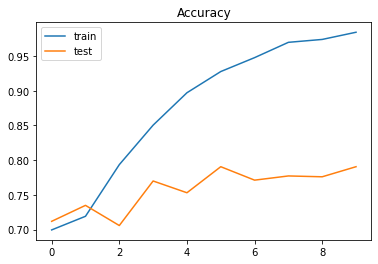

In [ ]:
#Accuracy Plot
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# Test a new complaint
new_tweet = ['is todays flight from Palm Springs Ca to JFK in NY Cancelled Flightled']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Reschedule and Refund', 'Baggage Issue','Phone and Online Booking', 'Extra Charges', 'Delay and Customer Service', 'Seating Preferences', 'Reservation Issue', 'Customer Experience']
print(pred, labels[np.argmax(pred)])

[[1.3455907e-05 1.3101944e-06 4.0634932e-06 1.0643199e-05 1.5105183e-05
  9.9992251e-01 2.0952546e-06 3.0809049e-05]] Seating Preferences


In [ ]:
import pickle

#saving model
model.save_weights(ROOT_DIR+"model_multiclass/multiclassComplaintClassifier.h5")

# saving tokenizer
with open(ROOT_DIR+'model_multiclass/tokenizerMulticlassComplaintClassification.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
import tensorflow.keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Text Preprocessing
import re
from nltk.corpus import stopwords

class MulticlassComplainInference:

  def __init__(self):
      self.load_models()

  def get_model(self):
      model = Sequential()
      model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
      model.add(SpatialDropout1D(0.2))
      model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
      model.add(Dense(8, activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      return model
  
  
  def load_models(self):
      with open(ROOT_DIR+'model_multiclass/tokenizerMulticlassComplaintClassification.pickle', 'rb') as handle:
          self.tokenizer = pickle.load(handle)

      self.model = self.get_model()
      self.model.load_weights(ROOT_DIR+"model_multiclass/multiclassComplaintClassifier.h5")

  def clean_text(self, txt):
    
      """
      removing all hashtags , punctuations, stop_words  and links, also stemming words 
      """
      txt = txt.lower()
      txt = re.sub(r"(?<=\w)nt", "not",txt) #change don't to do not cna't to cannot 
      txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
      txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
      txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
      txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
      txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
      txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
      txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ]) # stem & remove stop words
      txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
      return txt
  
  def predict_complaint(self, text):
      new_tweet = self.clean_text(text)
      seq = self.tokenizer.texts_to_sequences([new_tweet])
      padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
      pred = self.model.predict(padded)
      labels = ['Reschedule and Refund', 'Baggage Issue','Phone and Online Booking', 'Extra Charges', 
                'Delay and Customer Service', 'Seating Preferences', 'Reservation Issue', 'Customer Experience']
      print(pred, labels[np.argmax(pred)])
      return labels[np.argmax(pred)]


In [ ]:
mul = MulticlassComplainInference()

In [ ]:
mul.predict_complaint("@united I have never been mislead by a company as many times as I have this week by United Airlines!")

[[5.6744000e-05 1.3707737e-05 4.6854115e-05 2.4869654e-05 2.9237121e-05
  9.9966598e-01 5.9779791e-06 1.5672675e-04]] Seating Preferences


'Seating Preferences'